In [2]:
import import_ipynb
from Functions import *

importing Jupyter notebook from Functions.ipynb


# Main Model

In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # Placeholder for the classifier; initialized later dynamically
        self.classifier = None
        self.num_classes = num_classes

    def initialize_classifier(self, input_shape):
        # Pass a dummy tensor to the features to get the output size
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)  # Batch size of 1
            feature_map = self.features(dummy_input)
            flattened_size = feature_map.numel()
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(flattened_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, self.num_classes),
        )

    def forward(self, x):
        if self.classifier is None:
            self.initialize_classifier(x.shape[1:])  # Dynamically initialize based on input shape
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the feature map
        x = self.classifier(x)
        return Fun.softmax(torch.sum(x,dim=0))

# Get Training Data

In [4]:
def get_video_frames(path, N, size):
    # Find all video files in the specified path
    video_files = [f for f in os.listdir(path) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    if not video_files:
        raise ValueError("No video files found in the specified path.")
    
    # Choose a random video file
    video_file = random.choice(video_files)
    video_path = os.path.join(path, video_file)
    
    # Initialize the video capture
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # If N is larger than the number of frames in the video, adjust it
    if N > total_frames:
        raise ValueError(f"The video has only {total_frames} frames, but {N} frames were requested.")
    
    # Select a random starting frame index such that we can capture N consecutive frames
    start_frame = random.randint(0, total_frames - N)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Resize transformation
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])
    
    frames = []
    for _ in range(N):
        ret, frame = cap.read()
        if not ret:
            break
        # Convert the frame (BGR to RGB) and apply the resize transform
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_tensor = transform(frame_rgb)
        frames.append(frame_tensor)
    
    cap.release()
    
    # Stack frames and reshape to the desired output shape
    frames_tensor = torch.stack(frames).unsqueeze(0)  # Shape (1, N, 3, H, W)
    
    return frames#_tensor

# Convert Tensor to Numpy List

In [5]:
def t2nl(frames_tensor):
    # Remove the batch dimension (1, N, 3, H, W) -> (N, 3, H, W)
    frames_tensor = frames_tensor.squeeze(0)
    
    # Conve
    #rt each frame tensor to a NumPy array
    frame_list = [cv2.cvtColor(frame.permute(1, 2, 0).numpy(),cv2.COLOR_BGR2RGB) for frame in frames_tensor]
    
    return frame_list

# Training Function

In [6]:
def train(Path, State=None, N=3, Batch=10, Epochs=10, Steps=5, LR=1e-3):
    Model = CNN(2)
    Size = (300,300)
    
    if State is not None:
        Model.load_state_dict(States)
        Model.eval();
        
    Loss = []
    Accuracy = []
    LMin = 1e20

    start_time = time.time()  # Start timer

    for epoch in range(Epochs):
        epoch_start_time = time.time()  # Timer for each epoch
        optimizer = optim.Adam(Model.parameters(), lr=LR)
        total_loss = 0.0
        Correct0 = 0
        Correct1 = 0
        Total0 = 0
        Total1 = 0
        for batch in range(Batch):
            optimizer.zero_grad()
            
            Frames = get_video_frames(Path, N, Size)
            Frames = torch.stack(Frames)
    
            Target = torch.tensor([0.0,1.0]) if batch%2==0 else torch.tensor([1.0,0.0])
        
            if torch.equal(Target,torch.tensor([1.0,0.0])):
                steps = random.randint(1, Steps)
                for s in range(steps):
                    x,y,l = random.randint(0,3*Size[0]//4),random.randint(0,3*Size[1]//4),random.randint(10,Size[0]//5)
                    #print(x,y,l,x+l,y+l)
                    for p in range(N):
                        if random.random()>=0.5:
                            Frames[p] = AddOneInc1(Frames[p],x=x,y=y,l=l)
                    Frames[N // 2] = AddOneInc1(Frames[N // 2],x=x,y=y,l=l)
                       
            # Pixel Differences 
            diff_pix = [Frames[i]-Frames[i+1] for i in range(len(Frames)-1)]
            diff_pix = torch.stack(diff_pix)
            #print(diff_pix.shape)
            
            # Edges Frames
            edge_frames = [Edges_tensor(Frames[i])-Edges_tensor(Frames[i+1]) for i in range(len(Frames)-1)]
            edge_frames = torch.stack(edge_frames)
            #print(edge_frames.shape)
            
            Scores = [TSSIM(Frames[i].unsqueeze(0),Frames[i+1].unsqueeze(0)) for i in range(len(Frames)-1)]
            Score = [t[0].item() for t in Scores]
            SimScores = [t[1].squeeze(0) for t in Scores]
            SimScores = torch.stack(SimScores)
            #print(SimScores.shape)
            
            All = torch.cat((diff_pix,edge_frames,SimScores),dim=0)
            #print(All.shape)
            
            # Forward pass
            Pred = Model(All)
            
            if torch.equal(Target,torch.tensor([1.0,0.0])):
                Total1 += 1
                if torch.equal(Target,torch.round(Pred)):
                    Correct1 += 1
            else:
                Total0 += 1
                if torch.equal(Target,torch.round(Pred)):
                    Correct0 += 1
            
            # Calculate loss
            criterion = nn.BCELoss()
            loss = criterion(Pred, Target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            elapsed_time = time.time() - start_time
            avg_time_per_iter = elapsed_time / ((epoch * Batch) + batch + 1)
            remaining_iters = (Epochs * Batch) - ((epoch * Batch) + batch + 1)
            remaining_time = avg_time_per_iter * remaining_iters
            Mins = int(remaining_time//60)
            Secs = int(remaining_time%60)
            print(f'LR: {LR:0.4} Batch [{batch+1}/{Batch}], Loss: {loss.item():.4f} Time:{Mins}:{Secs}, Correct0: {Correct0}/{Total0}, Correct1: {Correct1}/{Total1},  [{Pred[0]:.2f},{Pred[1]:.2f}]', end='\r')

            # Display predictions on the frame
            Frame = cv2.cvtColor(Frames[N // 2].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB)
            Frame = cv2.putText(Frame, f'P: {int(torch.round(Pred[0]))}', (0, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 1)
            Frame = cv2.putText(Frame, f'T: {int(Target[0])}', (0, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
            cv2.imshow("Frame", Frame)
            cv2.waitKey(1)

        Loss.append(total_loss)
        Accuracy.append((Correct0+Correct1)/(Total0+Total1))
        print(f'\nEpoch [{epoch + 1}/{Epochs}], Loss: {total_loss / Batch:.6f}, Accuracy: {(Correct0+Correct1)/(Total0+Total1):.2f}, Correct1: {Correct1}/{Total1}')
        
        LR *= 0.75
    
    States = Model.state_dict()
    
    cv2.destroyAllWindows()
    return Loss,States,Accuracy

# Training

In [14]:
cv2.destroyAllWindows()

In [15]:
State = None

In [16]:
L,States,Accuracy = train('VDB',Batch=30,State=State,N=13,Epochs=10,Steps=5,LR=1e-5)

LR: 1e-05 Batch [30/30], Loss: 0.6819 Time:27:13, Correct0: 0/15, Correct1: 13/15,  [0.51,0.49]
Epoch [1/10], Loss: 0.694629, Accuracy: 0.43, Correct1: 13/15
LR: 7.5e-06 Batch [30/30], Loss: 0.6274 Time:26:35, Correct0: 8/15, Correct1: 7/15,  [0.53,0.47]
Epoch [2/10], Loss: 0.706119, Accuracy: 0.50, Correct1: 7/15
LR: 5.625e-06 Batch [30/30], Loss: 0.6220 Time:24:11, Correct0: 8/15, Correct1: 5/15,  [0.54,0.46]
Epoch [3/10], Loss: 0.708331, Accuracy: 0.43, Correct1: 5/15
LR: 4.219e-06 Batch [30/30], Loss: 0.6881 Time:21:11, Correct0: 8/15, Correct1: 7/15,  [0.50,0.50]
Epoch [4/10], Loss: 0.699221, Accuracy: 0.50, Correct1: 7/15
LR: 3.164e-06 Batch [30/30], Loss: 0.6839 Time:17:47, Correct0: 12/15, Correct1: 7/15,  [0.50,0.50]
Epoch [5/10], Loss: 0.681606, Accuracy: 0.63, Correct1: 7/15
LR: 2.373e-06 Batch [30/30], Loss: 0.6884 Time:14:54, Correct0: 9/15, Correct1: 5/15,  [0.50,0.50]
Epoch [6/10], Loss: 0.688539, Accuracy: 0.47, Correct1: 5/15
LR: 1.78e-06 Batch [30/30], Loss: 0.5343 Ti

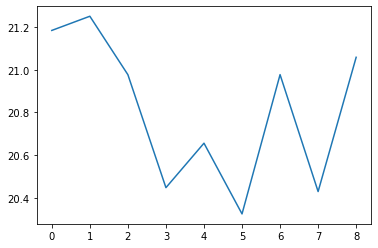

In [17]:
plt.plot(L[1:]) ##Cambios de Escenas

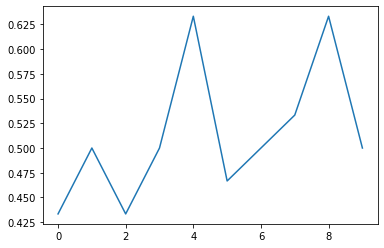

In [19]:
plt.plot(Accuracy)

In [20]:
torch.save(States,"StatesBID13N300x300.pth")

# Load and Predict

In [7]:
States = torch.load("StatesBID3N300x300.pth")

In [8]:
Size = (300,300)
N = 9
Model = CNN(2)
dummy = torch.rand((N-1)*3,3,Size[0],Size[1])
Model(dummy)
Model.load_state_dict(States)
Model.eval();

In [21]:
Frames = get_video_frames("AI Gen",N,(300,300))
diff_pix = [Frames[i]-Frames[i+1] for i in range(len(Frames)-1)]
diff_pix = torch.stack(diff_pix)
edge_frames = [Edges_tensor(Frames[i])-Edges_tensor(Frames[i+1]) for i in range(len(Frames)-1)]
edge_frames = torch.stack(edge_frames)
Scores = [TSSIM(Frames[i].unsqueeze(0),Frames[i+1].unsqueeze(0)) for i in range(len(Frames)-1)]
Score = [t[0].item() for t in Scores]
SimScores = [t[1].squeeze(0) for t in Scores]
SimScores = torch.stack(SimScores)
All = torch.cat((diff_pix,edge_frames,SimScores),dim=0)

In [22]:
Pred = Model(All)
print(f'Probability of Inconsistency: {Pred[0].item():.4f}')
print(f'Prediction: {round(Pred[0].item())}')

Probability of Inconsistency: 0.0007
Prediction: 0


In [23]:
Frames_Np = [cv2.cvtColor(Frames[n].permute(1, 2, 0).numpy(), cv2.COLOR_BGR2RGB) for n in range(len(Frames))]

In [24]:
ThroughFrames(Frames_Np)

In [ ]:
#Inconsistencia entrada y salida en cada secuencia
#Redes de diferentes tamanos de entrada para cada caja de inconsistencia